<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [66]:
# ## install finrl library
!pip install wrds
!pip install swig
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install pandas_market_calendars


zsh:1: command not found: apt-get
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /private/var/folders/ks/bjl76g8d4zxgw0m5p8z2pd9r0000gn/T/pip-req-build-h29_kopq
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /private/var/folders/ks/bjl76g8d4zxgw0m5p8z2pd9r0000gn/T/pip-req-build-h29_kopq
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit d25d902a6de54931a329adc38a2663e8f576adc4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/ks/bjl76g8d4zxgw0m5p8z2pd9r0000gn/T/pip-install-85ygn7pl/elegantrl_2cb7f0126a7244d7a1aae98c00b1934b
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/ks/bjl76g8d4zxgw0m5p8z2pd9r0000gn/T/pip-install-85ygn7pl/elegantrl_2


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [106]:
# ===========================
# Suppress Warnings
# ===========================
import warnings
warnings.filterwarnings("ignore")

# ===========================
# Standard Libraries
# ===========================
import os
import sys
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
matplotlib.use('Agg')  

# ===========================
# Enable Inline Plotting (Jupyter)
# ===========================
%matplotlib inline

# ===========================
# FinRL Imports
# ===========================
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
from finrl.main import check_and_make_directories
from finrl.config import (
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
)

# ===========================
# Create Necessary Directories
# ===========================
check_and_make_directories([
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR
])


# ===========================
# Custom Imports (model.py)
# ===========================
sys.path.append(os.path.abspath("."))  
from models import DRLEnsembleAgent

sys.path.append("../FinRL-Library")


<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [107]:
def process_csv_to_features(csv_path):
    # Step 1: Load Data
    df = pd.read_csv(csv_path)

    # Step 2: Identify 5-day and 7-day tickers
    day_values_per_tic = df.groupby('tic')['day'].apply(lambda x: sorted(x.unique())).reset_index()
    day_values_per_tic.columns = ['tic', 'unique_days']

    tics_5day = day_values_per_tic[day_values_per_tic['unique_days'].apply(lambda x: x == list(range(5)))]['tic']
    tics_7day = day_values_per_tic[day_values_per_tic['unique_days'].apply(lambda x: x == list(range(7)))]['tic']

    df_5day_full = df[df['tic'].isin(tics_5day)]
    df_7day_full = df[df['tic'].isin(tics_7day)]

    # Step 3: Apply Technical Indicators
    fe_ti = FeatureEngineer(
        use_technical_indicator=True,
        use_turbulence=False,
        user_defined_feature=False
    )
    df_5day_full = fe_ti.preprocess_data(df_5day_full)
    df_7day_full = fe_ti.preprocess_data(df_7day_full)

    # Step 4: Combine and Clean Index
    combined_df = pd.concat([df_5day_full, df_7day_full], ignore_index=False)
    combined_df.index = range(len(combined_df))

    # Step 5: Remove dates with only one ticker
    combined_df['date'] = pd.to_datetime(combined_df['date'])
    combined_df = combined_df[combined_df.groupby('date')['date'].transform('count') > 1]
    combined_df = combined_df.sort_values(['date', 'tic']).reset_index(drop=True)

    # Step 6: Apply Turbulence Feature
    fe_turb = FeatureEngineer(
        use_technical_indicator=False,
        use_turbulence=True,
        user_defined_feature=False
    )
    processed = fe_turb.preprocess_data(combined_df)

    # Step 7: Final Cleaning
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf, 0)

    return processed


In [108]:

processed = process_csv_to_features('data.csv')
print(processed.head())


Successfully added technical indicators
Successfully added technical indicators
Successfully added turbulence index
        date   close     high     low    open       volume     tic  day  \
0 2015-02-02  112.20  112.230  112.00  112.06    2792120.0     agg    0   
1 2015-02-02   91.46   91.480   91.46   91.48    3557487.0     bil    0   
2 2015-02-02  237.83  240.100  220.89  228.39       7421.0  btcusd    0   
3 2015-02-02  122.42  123.155  121.82  121.84    8885189.0     gld    0   
4 2015-02-02  201.92  202.030  197.86  200.05  163106969.0     spy    0   

       macd     boll_ub     boll_lb  rsi_30     cci_30  dx_30  close_30_sma  \
0  0.000000  112.593112  111.376888     0.0 -66.666667  100.0        112.20   
1  0.000000  112.593112  111.376888     0.0 -66.666667  100.0         91.46   
2  0.198333  245.911648  220.908352   100.0  66.666667  100.0        233.41   
3  0.000000  112.593112  111.376888     0.0 -66.666667  100.0        122.42   
4  0.000000  112.593112  111.376888   

In [ ]:
processed.tail(5)

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [109]:
def setup_drl_ensemble_agent(processed_df, 
                              indicators, 
                              train_start_date, 
                              train_end_date, 
                              trade_start_date, 
                              trade_end_date, 
                              rebalance_window=63, 
                              validation_window=63, 
                              initial_amount=1_000_000,
                              transaction_cost=0.001,
                              hmax=100,
                              reward_scaling=1e-4,
                              print_verbosity=5):
    """
    Setup DRLEnsembleAgent with flexible date and parameter configuration.
    """

    # 1. Calculate dynamic parameters
    stock_dimension = len(processed_df.tic.unique())
    state_space = 1 + 2 * stock_dimension + len(indicators) * stock_dimension

    # 2. Environment configuration
    env_kwargs = {
        "hmax": hmax,
        "initial_amount": initial_amount,
        "buy_cost_pct": transaction_cost,
        "sell_cost_pct": transaction_cost,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": indicators,
        "action_space": stock_dimension,
        "reward_scaling": reward_scaling,
        "print_verbosity": print_verbosity
    }

    # 3. Initialize DRLEnsembleAgent
    agent = DRLEnsembleAgent(
        df=processed_df,
        train_period=(train_start_date, train_end_date),
        val_test_period=(trade_start_date, trade_end_date),
        rebalance_window=rebalance_window,
        validation_window=validation_window,
        **env_kwargs
    )

    return agent


In [115]:
ensemble_agent = setup_drl_ensemble_agent(
    processed_df = processed,
    indicators = INDICATORS,
    train_start_date = '2016-02-02',
    train_end_date = '2023-01-03',
    trade_start_date = '2023-01-04',
    trade_end_date = '2025-04-11',
    rebalance_window = 63,
    validation_window = 63
)


[INIT] Unique trade dates from 2023-01-04 to 2025-04-11
[INIT] Total trading days: 570
[INIT] First 5 dates: <DatetimeArray>
['2023-01-04 00:00:00', '2023-01-05 00:00:00', '2023-01-06 00:00:00',
 '2023-01-09 00:00:00', '2023-01-10 00:00:00']
Length: 5, dtype: datetime64[ns]
[INIT] Last 5 dates: <DatetimeArray>
['2025-04-07 00:00:00', '2025-04-08 00:00:00', '2025-04-09 00:00:00',
 '2025-04-10 00:00:00', '2025-04-11 00:00:00']
Length: 5, dtype: datetime64[ns]

[INIT PREVIEW] ===== Rebalancing Schedule Summary =====
Iter     Train End    Val Start    Val End      Trade Start  Trade End   
126      2023-01-04 00:00:00 2023-01-04 00:00:00 2023-04-05 00:00:00 2023-04-05 00:00:00 2023-07-07 00:00:00
189      2023-04-05 00:00:00 2023-04-05 00:00:00 2023-07-07 00:00:00 2023-07-07 00:00:00 2023-10-05 00:00:00
252      2023-07-07 00:00:00 2023-07-07 00:00:00 2023-10-05 00:00:00 2023-10-05 00:00:00 2024-01-05 00:00:00
315      2023-10-05 00:00:00 2023-10-05 00:00:00 2024-01-05 00:00:00 2024-01-05 

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [121]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {
                      "batch_size": 128,
                      "buffer_size": 100000,
                      "learning_rate": 0.0003,
                      "learning_starts": 100,
                      "ent_coef": "auto_0.1",
                    }

TD3_model_kwargs = {
                      "batch_size": 100,
                      "buffer_size": 1000000,
                      "learning_rate": 0.001
                   }



timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                  'sac' : 10_000,
                 'td3' : 10_000,
                 }

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [116]:
import pandas as pd
import os
import matplotlib.pyplot as plt

def run_ensemble_and_generate_daily_return(ensemble_agent, 
                                            A2C_kwargs, PPO_kwargs, DDPG_kwargs, SAC_kwargs, TD3_kwargs, 
                                            timesteps_dict, 
                                            processed_df, 
                                            trade_start_date, trade_end_date, 
                                            rebalance_window, validation_window, 
                                            output_csv_name="df_daily_return.csv",
                                            initial_fund=1_000_000):
    """
    Runs DRL Ensemble Strategy, tracks continuous portfolio value, 
    calculates daily returns, and saves to CSV.
    """
    # === Step 1: Run Ensemble Strategy ===
    print("[INFO] Running Ensemble Strategy...")
    df_summary = ensemble_agent.run_ensemble_strategy(
        A2C_kwargs, PPO_kwargs, DDPG_kwargs, SAC_kwargs, TD3_kwargs, timesteps_dict
    )

    # === Step 2: Prepare Trade Dates ===
    unique_trade_date = processed_df[
        (processed_df.date >= trade_start_date) & (processed_df.date <= trade_end_date)
    ].date.unique()

    current_value = initial_fund
    portfolio_tracking = []
    is_first_file = True

    rebalance_points = list(range(rebalance_window + validation_window, len(unique_trade_date) + 1, rebalance_window))

    # === Step 3: Track Portfolio Value Across Rebalances ===
    for i in rebalance_points:
        file_path = f'results/account_value_trade_ensemble_{i}.csv'
        if os.path.exists(file_path):
            temp = pd.read_csv(file_path)

            if is_first_file:
                first_date = temp.loc[0, 'date']
                original_value = temp.loc[0, 'account_value']
                portfolio_tracking.append({
                    'date': first_date,
                    'portfolio_value': current_value,
                    'original_account_value': original_value
                })
                start_idx = 1
                is_first_file = False
            else:
                start_idx = 1

            for idx in range(start_idx, len(temp)):
                daily_return = temp.loc[idx, 'daily_return']
                date = temp.loc[idx, 'date']
                original_value = temp.loc[idx, 'account_value']
                if pd.notna(daily_return):
                    current_value *= (1 + daily_return)
                    portfolio_tracking.append({
                        'date': date,
                        'portfolio_value': current_value,
                        'original_account_value': original_value
                    })
        else:
            print(f"[Warning] File does not exist: {file_path}")

    df_portfolio = pd.DataFrame(portfolio_tracking)

    # === Step 4: Plot Portfolio Value ===
    plt.figure(figsize=(14,6))
    plt.plot(pd.to_datetime(df_portfolio['date']), df_portfolio['portfolio_value'], label='Continuous Portfolio Value')
    plt.plot(pd.to_datetime(df_portfolio['date']), df_portfolio['original_account_value'], label='Original (Resetting) Account Value', linestyle='--')
    plt.title('Portfolio Value: Continuous vs Original')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()

    # === Step 5: Calculate Daily Returns ===
    df_daily_return = df_portfolio.copy()
    df_daily_return["daily_return"] = df_daily_return["portfolio_value"].pct_change()
    df_daily_return = df_daily_return.infer_objects(copy=False)
    df_daily_return.loc[0, "daily_return"] = 0.0
    df_daily_return = df_daily_return[["date", "daily_return"]]

    # === Step 6: Save to CSV ===
    df_daily_return.to_csv(output_csv_name, index=False)
    print(f"[INFO] Daily return saved to: {output_csv_name}")

    return df_daily_return


[INFO] Running Ensemble Strategy...
============Start Ensemble Strategy============
turbulence_threshold:  82.25897481973143
======Model training from:  2016-02-02 to  2023-01-04 00:00:00
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_31


-------------------------------------
| time/                 |           |
|    fps                | 770       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -12.9     |
|    explained_variance | -0.335    |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 21.6      |
|    reward             | 1.1501445 |
|    std                | 1.01      |
|    value_loss         | 3.28      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 771        |
|    iterations         | 200        |
|    time_elapsed       | 1          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -12.8      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

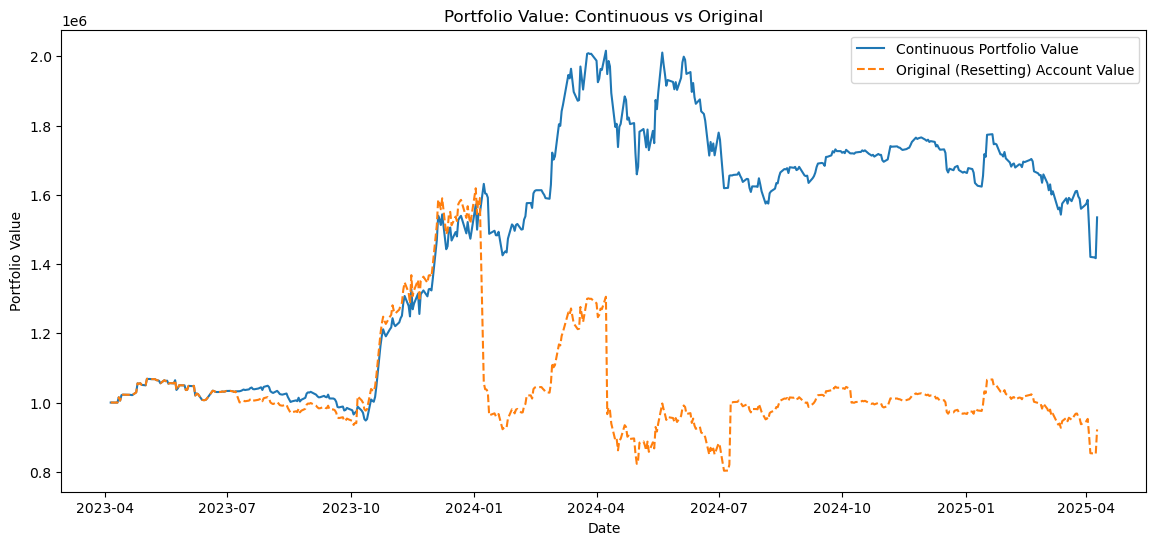

[INFO] Daily return saved to: df_daily_return_ensemble.csv


In [120]:
df_daily_return = run_ensemble_and_generate_daily_return(
    ensemble_agent = ensemble_agent,
    A2C_kwargs = A2C_model_kwargs,
    PPO_kwargs = PPO_model_kwargs,
    DDPG_kwargs = DDPG_model_kwargs,
    SAC_kwargs = SAC_model_kwargs,
    TD3_kwargs = TD3_model_kwargs,
    timesteps_dict = timesteps_dict,
    processed_df = processed,
    trade_start_date = '2023-01-04',
    trade_end_date = '2025-04-11',
    rebalance_window = 63,
    validation_window = 63,
    output_csv_name = "df_daily_return_ensemble.csv"
)
